In [1]:
import pandas as pd

In [1]:
import sklearn
print(sklearn.__version__)

1.5.0


In [2]:
#load data
# segment = 'NTC'
# X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')

In [3]:
#jied
def xgbc_model_builder3(n_estimators = 100,
                          max_depth = 6,
                          learning_rate=0.3,
                          subsample = 1,
                          colsample_bytree = 1,
                          colsample_bylevel = 1,
                          min_child_weight =1,
                          gamma = 0,
                          reg_alpha = 0,
                          reg_lambda = 1,
                          eta = 0.3,
                       random_state = 42):
    
    import xgboost as xgb
    model = xgb.XGBClassifier(n_estimators = n_estimators,
                              max_depth = max_depth,
                              learning_rate=learning_rate,
                              subsample = subsample,
                              colsample_bytree = colsample_bytree,
                              colsample_bylevel = colsample_bylevel,
                              min_child_weight =min_child_weight,
                              gamma = gamma,
                              reg_alpha = reg_alpha,
                              reg_lambda = reg_lambda,
                              eta = eta,
                              random_state = 42,
                              enable_categorical=True,
                              n_jobs = -1,
                              objective = "binary:logistic")
    return model

In [4]:
def XGBC_ohe_model_auc(cleaned_df, xgbc_model, segment):
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.metrics import mean_absolute_error
    import pandas as pd
    import numpy as np
    from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
    from catboost.utils import get_confusion_matrix, get_roc_curve, get_fnr_curve, get_fpr_curve
    from sklearn.metrics import RocCurveDisplay
    from sklearn import metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    y = 'D3_within12months'
    X = cleaned_df.drop(columns = [y, 'loan_account_no'])
    y = cleaned_df[y]
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 11, train_size = 0.8,
                                                        test_size = 0.2, stratify = y)

    object_columns = X.select_dtypes(include=['object','category']).columns

    from sklearn.preprocessing import OneHotEncoder
    
    ohe = OneHotEncoder(sparse_output = False,drop='first').set_output(transform='pandas')
    
    one_hot_encoded_object_X_train = ohe.fit_transform(X_train[object_columns])
    one_hot_encoded_object_X_test = ohe.transform(X_test[object_columns])
    
    final_X_train = pd.concat([one_hot_encoded_object_X_train, X_train.select_dtypes('number')], axis=1)
    final_X_test = pd.concat([one_hot_encoded_object_X_test, X_test.select_dtypes('number')], axis=1)

    X_train = final_X_train
    X_test = final_X_test

    model = xgbc_model

    model.fit(X_train, y_train,
                   eval_set = [(X_test, y_test)])

    y_pred_proba = model.predict_proba(X_test)[:,1]

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_proba)
    
    #compute optimal threshold based on roc_auc curve only
    opt = true_positive_rate - false_positive_rate
    tp_fp_diff = pd.DataFrame({'thresholds': threshold, 'tpr_fpr': opt})

    max_index = tp_fp_diff.tpr_fpr.argmax()
    THRESHOLD = tp_fp_diff.iloc[max_index][0]
    
    y_pred = np.where(y_pred_proba > THRESHOLD, 1, 0)

    plt.subplots(1, figsize = (5,5))
    luh = roc_auc_score(y_test, y_pred_proba)
    plt.title(f'ROC_AUC Curve: {luh:.2f}')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0,1], ls = "--")
    plt.plot([0,0],[1,0], c= ".7"), plt.plot([1,1], c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print(classification_report(y_test, y_pred, target_names = ['Good Customer','Bad Customer']))
    cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(cnf_matrix)
    print(tn, fp, fn, tp)

    booster = model.get_booster()
    
    sns.distplot(y_pred_proba)
    plt.show()

    feat_importances = model.feature_importances_
    feature_names = booster.feature_names

    feat_imp_df = pd.DataFrame({
        'variable':feature_names,
        'feature_importances':feat_importances
    })
    
    feat_imp_df.to_csv(f'./Feature_Importance/featimportance_XGB_{segment}.csv', index=False)

    feat_imp_df = feat_imp_df.sort_values(by='feature_importances', ascending=False)
    print(feat_imp_df[:20])

[0]	validation_0-logloss:0.31025
[1]	validation_0-logloss:0.30227
[2]	validation_0-logloss:0.29680
[3]	validation_0-logloss:0.29209
[4]	validation_0-logloss:0.28935
[5]	validation_0-logloss:0.28737
[6]	validation_0-logloss:0.28580
[7]	validation_0-logloss:0.28498
[8]	validation_0-logloss:0.28390
[9]	validation_0-logloss:0.28306
[10]	validation_0-logloss:0.28244
[11]	validation_0-logloss:0.28198
[12]	validation_0-logloss:0.28142
[13]	validation_0-logloss:0.28138
[14]	validation_0-logloss:0.28140
[15]	validation_0-logloss:0.28110
[16]	validation_0-logloss:0.28045
[17]	validation_0-logloss:0.27995
[18]	validation_0-logloss:0.27983
[19]	validation_0-logloss:0.27954
[20]	validation_0-logloss:0.27945
[21]	validation_0-logloss:0.27939
[22]	validation_0-logloss:0.27928
[23]	validation_0-logloss:0.27895
[24]	validation_0-logloss:0.27856
[25]	validation_0-logloss:0.27824
[26]	validation_0-logloss:0.27820
[27]	validation_0-logloss:0.27827
[28]	validation_0-logloss:0.27809
[29]	validation_0-loglos

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_1864\2970468033.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


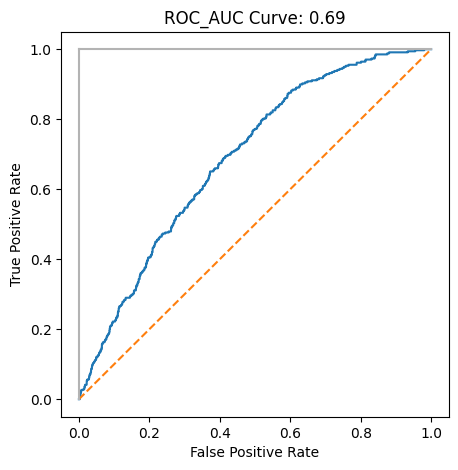

               precision    recall  f1-score   support

Good Customer       0.96      0.47      0.63      3492
 Bad Customer       0.13      0.81      0.22       338

     accuracy                           0.50      3830
    macro avg       0.55      0.64      0.43      3830
 weighted avg       0.89      0.50      0.59      3830

[[1632 1860]
 [  64  274]]
1632 1860 64 274


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_1864\2970468033.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


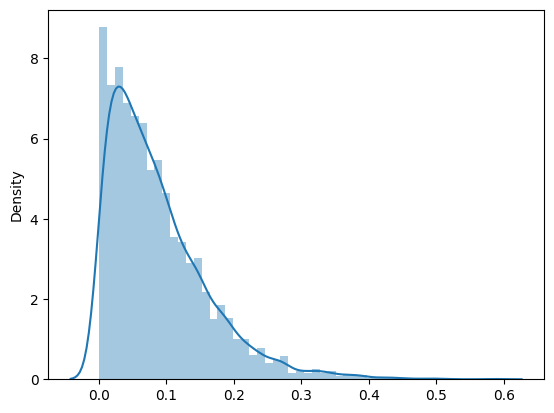

                                          variable  feature_importances
28                           res_state_grp_GROUP_C             0.095612
29                  res_resident_status_grp_RENTED             0.074681
15                              branch_grp_GROUP_D             0.066757
35                          number_of_installments             0.063813
0             product_description_USED_TWO-WHEELER             0.053952
17                          asset_model_grp_AVENIS             0.048861
5                            marital_status_SINGLE             0.045189
32                             down_payment_amount             0.039670
14                              branch_grp_GROUP_C             0.030796
3                                      gender_MALE             0.027290
26                            res_city_grp_GROUP_D             0.026847
1   occupation_type_SELF_EMPLOYED_NON_PROFESSIONAL             0.025711
24                            res_city_grp_GROUP_B             0

In [5]:
xgbc_ntc_v3 = xgbc_model_builder3(n_estimators = 395,
                          max_depth = 2,
                          learning_rate=0.28267052670545584,
                          subsample =  0.8736932106048627,
                          colsample_bytree = 0.8721230154351118,
                          colsample_bylevel = 0.9299702033681603,
                          min_child_weight =9,
                          gamma = 0.19897441739799793,
                          reg_alpha = 4,
                          reg_lambda = 1,
                          eta = 0.1000998503939086,
                          random_state = 42)

segment = 'NTC'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
XGBC_ohe_model_auc(X, xgbc_ntc_v3, segment)

[0]	validation_0-logloss:0.31866
[1]	validation_0-logloss:0.31316
[2]	validation_0-logloss:0.30941
[3]	validation_0-logloss:0.30514
[4]	validation_0-logloss:0.30354
[5]	validation_0-logloss:0.30240
[6]	validation_0-logloss:0.30069
[7]	validation_0-logloss:0.30008
[8]	validation_0-logloss:0.29929
[9]	validation_0-logloss:0.29834
[10]	validation_0-logloss:0.29826
[11]	validation_0-logloss:0.29764
[12]	validation_0-logloss:0.29763
[13]	validation_0-logloss:0.29712
[14]	validation_0-logloss:0.29712
[15]	validation_0-logloss:0.29711
[16]	validation_0-logloss:0.29711
[17]	validation_0-logloss:0.29711
[18]	validation_0-logloss:0.29710
[19]	validation_0-logloss:0.29647
[20]	validation_0-logloss:0.29649
[21]	validation_0-logloss:0.29596
[22]	validation_0-logloss:0.29623
[23]	validation_0-logloss:0.29620
[24]	validation_0-logloss:0.29589
[25]	validation_0-logloss:0.29588
[26]	validation_0-logloss:0.29590
[27]	validation_0-logloss:0.29590
[28]	validation_0-logloss:0.29588
[29]	validation_0-loglos

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_1864\2970468033.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


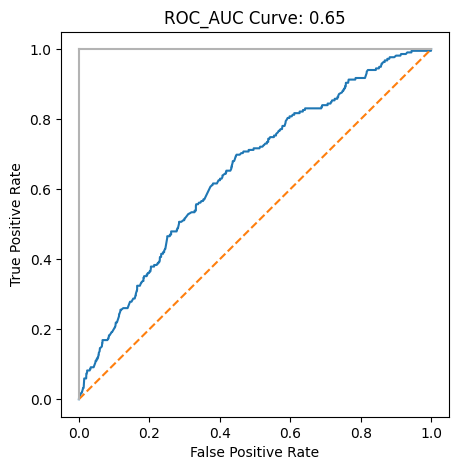

               precision    recall  f1-score   support

Good Customer       0.95      0.55      0.70      2177
 Bad Customer       0.14      0.69      0.23       219

     accuracy                           0.57      2396
    macro avg       0.54      0.62      0.46      2396
 weighted avg       0.87      0.57      0.66      2396

[[1207  970]
 [  67  152]]
1207 970 67 152


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_1864\2970468033.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


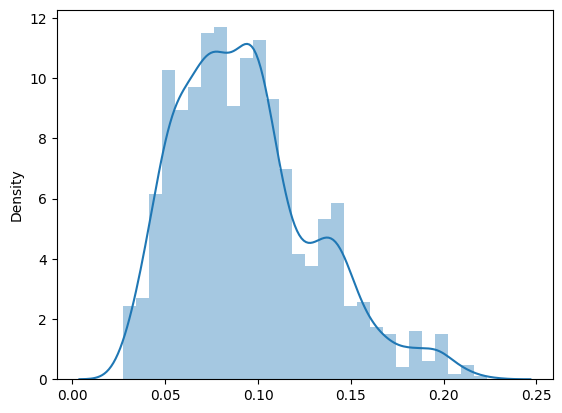

                                          variable  feature_importances
35                          number_of_installments             0.115977
31                                             age             0.113994
29                  res_resident_status_grp_RENTED             0.106458
40                                        dp_ratio             0.104455
28                           res_state_grp_GROUP_C             0.092320
15                              branch_grp_GROUP_D             0.091475
32                             down_payment_amount             0.089301
39                                  monthly_income             0.081007
26                            res_city_grp_GROUP_D             0.069501
36                                 loan_asset_cost             0.068211
1   occupation_type_SELF_EMPLOYED_NON_PROFESSIONAL             0.067301
30                       res_years_at_current_city             0.000000
22                          asset_model_grp_OTHERS             0

In [6]:
xgbc_low_CIBIL_v3 = xgbc_model_builder3(n_estimators = 317,
                          max_depth = 9,
                          learning_rate=0.27449790266313423,
                          subsample =  0.6254233401144095,
                          colsample_bytree = 0.8423839899124046,
                          colsample_bylevel = 0.8950877702656028,
                          min_child_weight =72,
                          gamma = 9.766155382529167,
                          reg_alpha = 1,
                          reg_lambda = 32,
                          eta = 0.19526017570266982,
                          random_state = 42)

segment = 'low_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
XGBC_ohe_model_auc(X, xgbc_low_CIBIL_v3, segment)

[0]	validation_0-logloss:0.24886
[1]	validation_0-logloss:0.23924
[2]	validation_0-logloss:0.23313
[3]	validation_0-logloss:0.22885
[4]	validation_0-logloss:0.22678
[5]	validation_0-logloss:0.22501
[6]	validation_0-logloss:0.22421
[7]	validation_0-logloss:0.22312
[8]	validation_0-logloss:0.22267
[9]	validation_0-logloss:0.22216
[10]	validation_0-logloss:0.22140
[11]	validation_0-logloss:0.22076
[12]	validation_0-logloss:0.22118
[13]	validation_0-logloss:0.22103
[14]	validation_0-logloss:0.22082
[15]	validation_0-logloss:0.22065
[16]	validation_0-logloss:0.22040
[17]	validation_0-logloss:0.21980
[18]	validation_0-logloss:0.21949
[19]	validation_0-logloss:0.21924
[20]	validation_0-logloss:0.21898
[21]	validation_0-logloss:0.21919
[22]	validation_0-logloss:0.21910
[23]	validation_0-logloss:0.21892
[24]	validation_0-logloss:0.21889
[25]	validation_0-logloss:0.21882
[26]	validation_0-logloss:0.21894
[27]	validation_0-logloss:0.21926
[28]	validation_0-logloss:0.21905
[29]	validation_0-loglos

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_1864\2970468033.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


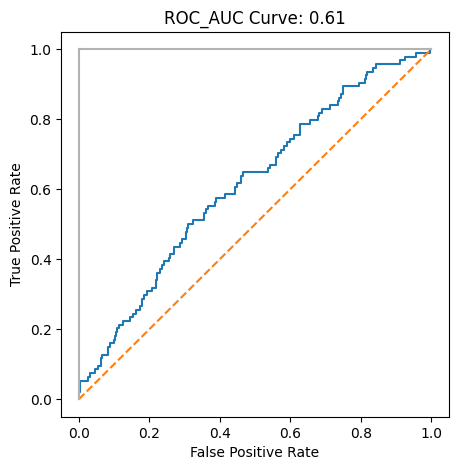

               precision    recall  f1-score   support

Good Customer       0.96      0.69      0.80      1475
 Bad Customer       0.09      0.49      0.15        94

     accuracy                           0.68      1569
    macro avg       0.52      0.59      0.48      1569
 weighted avg       0.90      0.68      0.76      1569

[[1020  455]
 [  48   46]]
1020 455 48 46


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_1864\2970468033.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


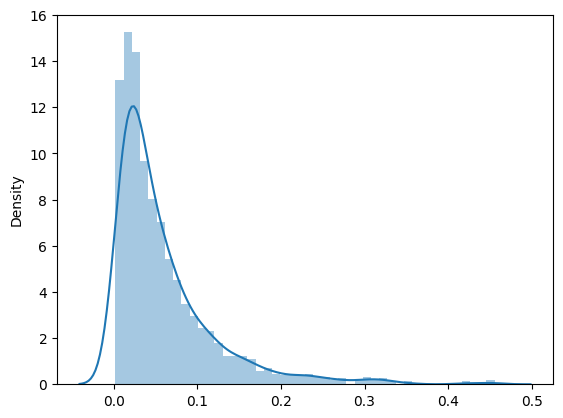

                                          variable  feature_importances
29                  res_resident_status_grp_RENTED             0.123646
17                          asset_model_grp_AVENIS             0.095328
0             product_description_USED_TWO-WHEELER             0.085512
28                           res_state_grp_GROUP_C             0.053856
15                              branch_grp_GROUP_D             0.036260
21                           asset_model_grp_NTORQ             0.032199
34                                   interest_rate             0.031463
24                            res_city_grp_GROUP_B             0.030505
4                           marital_status_MARRIED             0.030231
25                            res_city_grp_GROUP_C             0.028668
35                          number_of_installments             0.028625
32                             down_payment_amount             0.026943
22                          asset_model_grp_OTHERS             0

In [7]:
xgbc_mid_CIBIL_v3 = xgbc_model_builder3(n_estimators = 395,
                          max_depth = 2,
                          learning_rate=0.28267052670545584,
                          subsample =  0.8736932106048627,
                          colsample_bytree = 0.8721230154351118,
                          colsample_bylevel = 0.9299702033681603,
                          min_child_weight =9,
                          gamma = 0.19897441739799793,
                          reg_alpha = 4,
                          reg_lambda = 1,
                          eta = 0.1000998503939086,
                          random_state = 42)

segment = 'mid_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
XGBC_ohe_model_auc(X, xgbc_mid_CIBIL_v3, segment)

[0]	validation_0-logloss:0.17802
[1]	validation_0-logloss:0.16265
[2]	validation_0-logloss:0.15220
[3]	validation_0-logloss:0.14493
[4]	validation_0-logloss:0.13995
[5]	validation_0-logloss:0.13673
[6]	validation_0-logloss:0.13474
[7]	validation_0-logloss:0.13305
[8]	validation_0-logloss:0.13206
[9]	validation_0-logloss:0.13130
[10]	validation_0-logloss:0.13020
[11]	validation_0-logloss:0.12971
[12]	validation_0-logloss:0.12954
[13]	validation_0-logloss:0.12935
[14]	validation_0-logloss:0.12906
[15]	validation_0-logloss:0.12903
[16]	validation_0-logloss:0.12905
[17]	validation_0-logloss:0.12869
[18]	validation_0-logloss:0.12875
[19]	validation_0-logloss:0.12844
[20]	validation_0-logloss:0.12852
[21]	validation_0-logloss:0.12870
[22]	validation_0-logloss:0.12870
[23]	validation_0-logloss:0.12871
[24]	validation_0-logloss:0.12875
[25]	validation_0-logloss:0.12880
[26]	validation_0-logloss:0.12874
[27]	validation_0-logloss:0.12866
[28]	validation_0-logloss:0.12882
[29]	validation_0-loglos

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_1864\2970468033.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


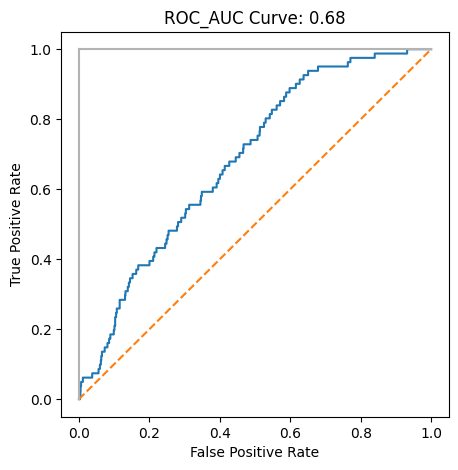

               precision    recall  f1-score   support

Good Customer       0.99      0.40      0.57      2565
 Bad Customer       0.04      0.88      0.08        81

     accuracy                           0.42      2646
    macro avg       0.52      0.64      0.33      2646
 weighted avg       0.96      0.42      0.56      2646

[[1031 1534]
 [  10   71]]
1031 1534 10 71


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_1864\2970468033.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


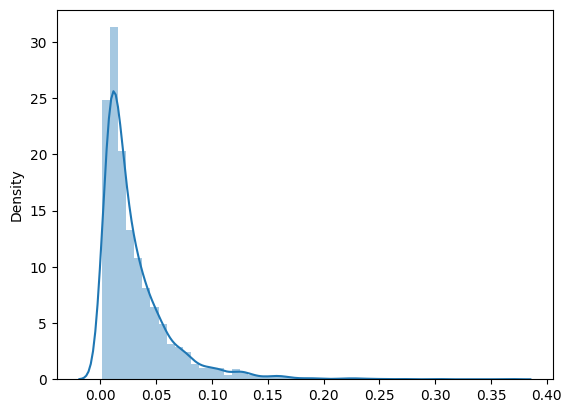

                                          variable  feature_importances
15                              branch_grp_GROUP_D             0.132953
16                          asset_model_grp_ACTIVA             0.084016
27                           res_state_grp_GROUP_B             0.074352
28                           res_state_grp_GROUP_C             0.073240
29                  res_resident_status_grp_RENTED             0.065249
8                         manufacturer_grp_GROUP_B             0.050634
25                            res_city_grp_GROUP_C             0.050328
35                          number_of_installments             0.042102
32                             down_payment_amount             0.034926
34                                   interest_rate             0.034032
40                                        dp_ratio             0.032014
14                              branch_grp_GROUP_C             0.031709
31                                             age             0

In [8]:
xgbc_high_CIBIL_v3 = xgbc_model_builder3(n_estimators = 409,
                          max_depth = 4,
                          learning_rate=0.27280612062363463,
                          subsample =  0.7700623497964979,
                          colsample_bytree = 0.6488152939379115,
                          colsample_bylevel = 0.7200762468698007,
                          min_child_weight =50,
                          gamma = 0.5158278167282759,
                          reg_alpha = 3,
                          reg_lambda = 1,
                          eta = 0.10903538202225403,
                          random_state = 42)

segment = 'high_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
XGBC_ohe_model_auc(X, xgbc_high_CIBIL_v3, segment)